## 1.1 Fix random number generator

In [1]:
import numpy as np 
import pandas as pd 
import random
import torch
import os

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## 1.2 Set the parameters of network training

The location of the data

In [2]:
# Path to the original training sample
PATH_TO_TRAIN = '../input/plates/plates/train'
# Path to the test sample
PATH_TO_TEST = '../input/plates/plates/test'
# Path to the sample on which the model will be trained
TRAIN_DIR = 'train'
# Path to the sample where the quality of the model will be evaluated
VAL_DIR = 'val'
# Path to the test sample
TEST_DIR = 'test'

Class name

In [3]:
labels = ['cleaned', 'dirty']

Training parameters

In [4]:
# Number of examples from the training sample, after which the gradient step is made
batch_size = 50
# The learning rate of the neural network
lr = 1.0e-3
# The number of training epochs
num_epoch = 100

# each valid_split image of the training sample will be deferred for the validation sample
valid_split = 10

In [5]:
# lr_scheduler.StepLR parameters
# Number of epochs after which the learning rate decreases
step_size = 7
gamma=0.1

## 1.3 Studying the original data

In [6]:
from PIL import Image
from random import sample
from os.path import join
from os import listdir
import matplotlib.pyplot as plt

Visualization of the training sample

cleaned


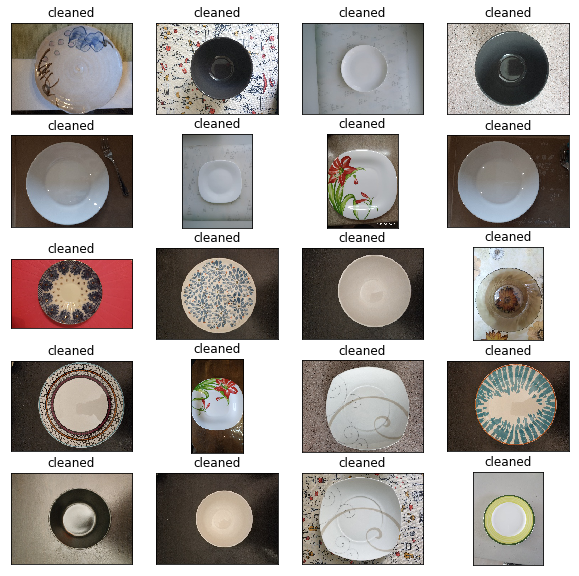

dirty


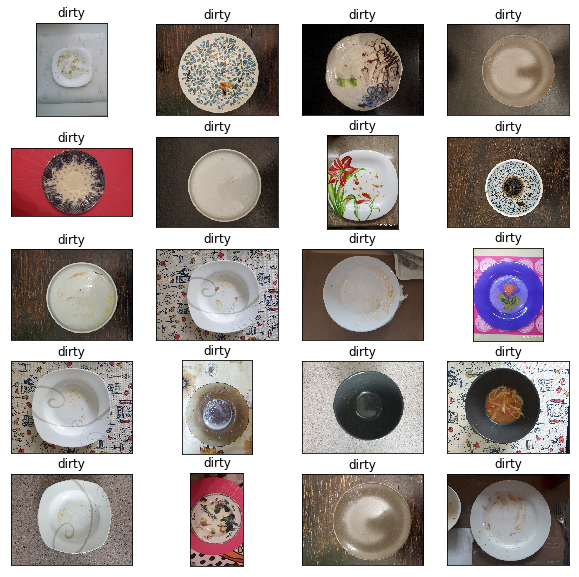

In [7]:
for label in labels:
    print(label)
    # Path to training data of the label class
    PATH = join(PATH_TO_TRAIN, label)
    # Number of images in this folder
    n = len(listdir(PATH))
    plt.figure(figsize=(10, 10))
    for i,image in enumerate(listdir(PATH)):
        plt.subplot(n/4, 4, i+1)
        img = Image.open(join(PATH,image))
        plt.imshow(img)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
    plt.show()

Visualization of a part of the test sample

Test set


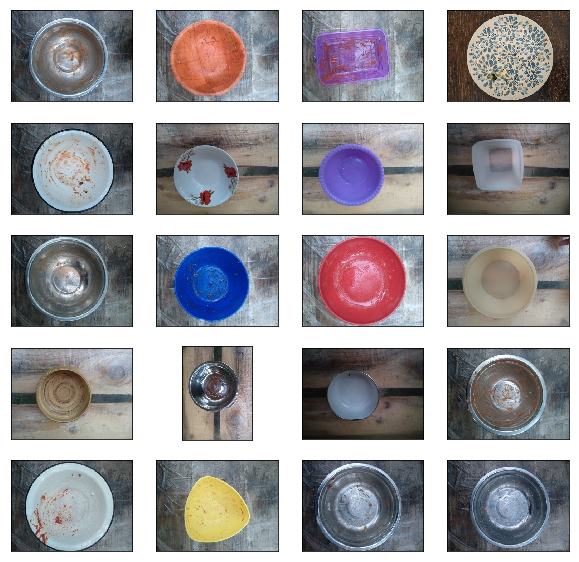

In [8]:
n_samples = 20
# Select random 20 images from the test sample
sub_sample = sample(listdir(PATH_TO_TEST), n_samples)
plt.figure(figsize=(10, 10))
print('Test set')
for i,image in enumerate(sub_sample):
    plt.subplot(n_samples/4, 4, i+1)
    img = Image.open(join(PATH_TO_TEST, image))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

## 1.4 Data pre-processing. Division into training and validation samples

In [9]:
from shutil import copy
from os import makedirs

Divide the original training sample into **training** and **validation**. To do this, create the `train` and `val` folders and create the `cleaned` and `dirty`folders in each of them.

In [10]:
for dir_name in [TRAIN_DIR, VAL_DIR]:
    for label in labels:
        makedirs(join(dir_name, label),
                exist_ok=True)

We will put each `valid_split` image from the original training sample in the validation sample (in the `val` folder), the remaining images will be copied to the `train` folder

In [11]:
for label in labels:
    
    # The folder from which we will copy files 
    source_dir = join(PATH_TO_TRAIN, label)
    
    for i, file_name in enumerate(listdir(source_dir)):
        
        # Select where to copy the file
        if i % 10 != 0:
            dest_dir = join(TRAIN_DIR, label)
        else:
            dest_dir = join(VAL_DIR, label)
            
        # Copy the file to the selected folder
        copy(join(source_dir, file_name),
            (join(dest_dir, file_name)))

## 1.5. Data augmentation

Set the sequence of image transformations to increase the variety of images.

In [12]:
from torchvision import transforms 

In [13]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(270),
    transforms.CenterCrop(224),
    transforms.RandomVerticalFlip(),
    #transforms.RandomResizedCrop(224, scale=(0.5,1)),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(0.5, 0.6, 0.3, 0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## 1.6 The creation of a "data loaders" for training and validation

In [14]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [15]:
# Generates a dataset from images in the specified folder
train_dataset = ImageFolder(TRAIN_DIR, train_transforms)
val_dataset = ImageFolder(VAL_DIR, train_transforms)

In [16]:
# Loads data from previously generated datasets
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=batch_size)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=batch_size)

## 1.7 Visualization of the training sample

In [17]:
def show_batch(X_batch, y_batch, batch_size):
    plt.figure(figsize=(10, 5))
    for i, (image_tensor, class_index) in enumerate(zip(X_batch, y_batch)):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image_tensor.permute(1, 2, 0).numpy()
        image = std * image + mean
        plt.subplot(batch_size/4, 4, i+1)
        plt.imshow(image)
        plt.title(labels[class_index])
        plt.xticks([])
        plt.yticks([])      
    plt.show()

Batch 1


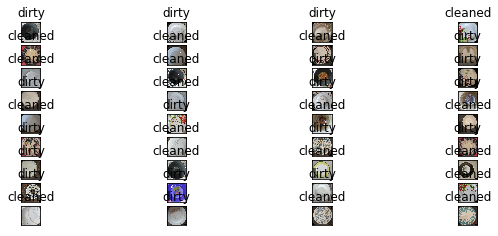

Batch 2


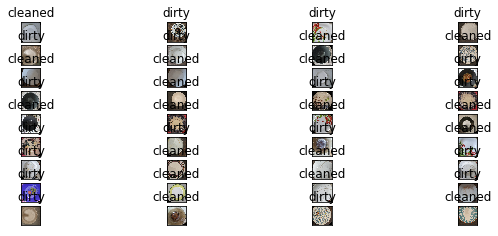

Batch 3


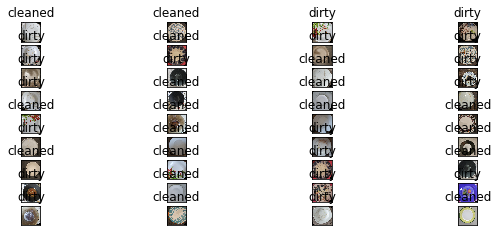

In [18]:
for i in range(3):
    print('Batch', i+1)
    X_batch, y_batch = next(iter(train_dataloader))
    show_batch(X_batch, y_batch, batch_size)

# 2. Creating a neural network

## 2.1. Loading the base model

In [19]:
from torchvision import models
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler

In [20]:
# Loading a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# "Freezing" convolutional layers of the neural network
# (fixation of scales)
for param in model.parameters():
    param.requires_grad = False

# Adding a fully connected layer
# for binary classification
model.fc = Linear(model.fc.in_features, 2)

# Shifting the calculations to the GPU
# if it is not available on the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 113403959.98it/s]


In [21]:
# Setting the loss function
loss = CrossEntropyLoss()

In [22]:
# Setting the optimizer
#optimizer = Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [23]:
scheduler = lr_scheduler.StepLR(optimizer,
                                step_size=step_size,
                                gamma=gamma)

## 2.2. Neural network training

In [24]:
def train_model(model,
                loss,
                optimizer,
                scheduler,
                num_epochs,
                verbose = False):
    
    # We will record intermediate results 
    #for further visualization of the training
    train_accuracy_history = []
    train_loss_history = []
    val_accuracy_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        if verbose == True:
            print()
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        # At each epoch we will first train the network 
        #then check its quality on a validation sample
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
        
            running_loss = 0
            running_acc = 0
            
            # Load the data and reset the gradient
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # During the training phase we calculate the error 
                #on the test sample and make a gradient step
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                running_loss += loss_value.data.cpu()
                running_acc += (preds_class == labels.data).float().mean().data.cpu()
            
            # The average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
        
            # Remember the error and accuracy 
            #values for further visualization
            if phase == 'train':
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            
            if verbose == True:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
    return train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history

In [25]:
history = train_model(model,
                      loss,
                      optimizer,
                      scheduler,
                      num_epochs=num_epoch);

# 3. Learning visualization

In [26]:
from torch import nn

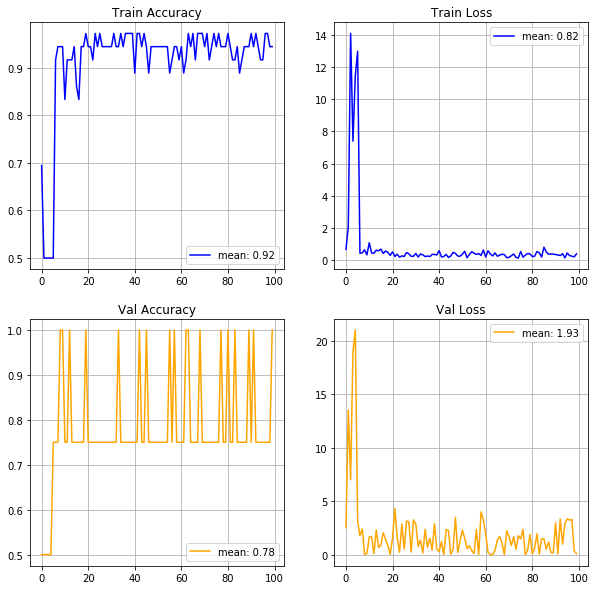

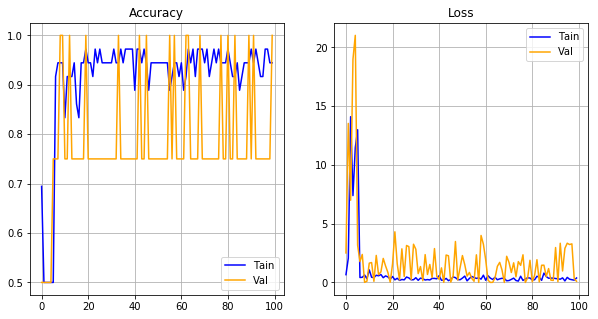

In [27]:
# Draw Accuracy and Loss graphs for Training and validation samples
titles = ['Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss']
plt.figure(figsize=(10, 10))
for i, image in enumerate(history):
    plt.subplot(2, 2, i+1)
    plt.title(titles[i])
    plt.grid()
    if i == 0 or i == 1:
        color = 'b'
    else:
        color = 'orange'
    plt.plot(image,c=color, label= 'mean: %.2f' % np.array(image).mean())
    plt.legend(loc='best')
plt.show()

# Draw combined Accuracy and Loss graphs for Training and validation samples
titles_ = ['Accuracy','Loss']
plt.figure(figsize=(10, 5))
k=0
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(history[0+k], label='Tain', c='b')
    plt.plot(history[2+k], label='Val', c='orange')
    plt.title(titles_[i])
    plt.grid()
    plt.legend(loc='best')
    k += 1

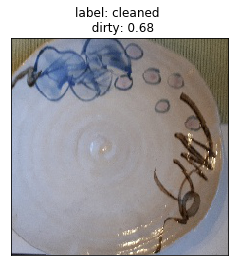

In [28]:
model.eval()

for _ in range(3):
    val_predictions = []
    val_img_paths = []
    for inputs, labels_ in val_dataloader:
        inputs = inputs.to(device)
        labels_ = labels_.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        val_predictions.append(nn.functional.softmax(preds, dim=1)[:,1].data.cpu())
        labels_ = labels_.cpu().numpy()
        predict = val_predictions[0] > 0.5
        val_predictions = val_predictions[0].numpy()
        predict = predict.numpy()
        ind = (labels_ == predict)
        for i, image_tensor in enumerate(inputs):
            if ind[i] == False:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = image_tensor.cpu().permute(1, 2, 0).numpy()
                image = std * image + mean
                plt.imshow(image)
                plt.title('label: %s \n  %s: %.2f' % (labels[labels_[i]],
                                                      labels[predict[i]],
                                                      val_predictions[i]))
                                                                   
                plt.xticks([])
                plt.yticks([]) 
                plt.show()
        print()

# 4. Classification of the test sample

In [29]:
from shutil import copytree

In [30]:
# Copy the test images 
#to the 'test/unknown' folder 
#for proper operation of the ImageFolder
copytree(PATH_TO_TEST,
         join(TEST_DIR, 'unknown'))

'test/unknown'

In [31]:
from torchvision import transforms, models, datasets

In [32]:
# Modify ImageFolder so that 
#It displays not only the image with its label, 
#but also the path to the image
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths,self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [33]:
test_dataset = ImageFolderWithPaths(TEST_DIR, val_transforms)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=batch_size)

In [34]:
# Let's move the model to the evaluation state
# (network settings will not change)
model.eval()

# Predictions
test_predictions = []
# The image paths
test_img_paths = []

In [35]:
from tqdm import tqdm
# In the loop, we get the Batch with images, 
# the class label ('unknown'), and the paths to the images
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        # Consider the predictions of the model
        preds = model(inputs)
    # Using softmax we bring them to probabilities
    # As a result, we get the probability of the first class ('dirty plate')
    test_predictions.append(nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    # Paths are used to visualize and save predictions
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


## 4.1. Visualization of predictions

In [36]:
 prediction = dict(zip(test_img_paths, test_predictions))

Test set


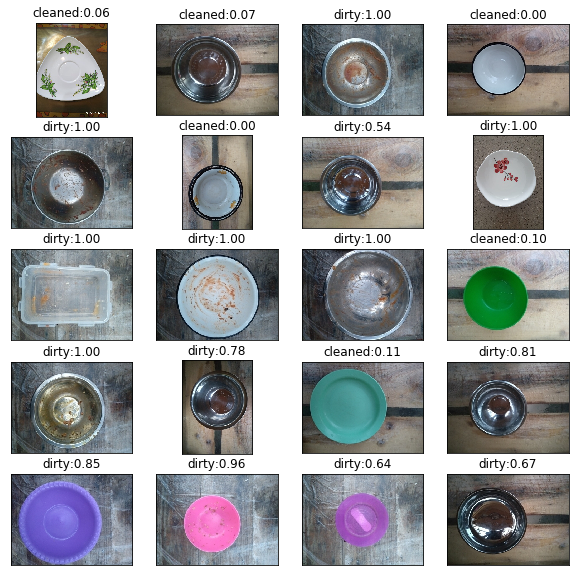

In [37]:
# Visualization of the predictions of the classifier
n_samples = 20
sub_sample = sample(test_img_paths, n_samples)
plt.figure(figsize=(10, 10))
print('Test set')
for i,image in enumerate(sub_sample):
    plt.subplot(n_samples/4, 4, i+1)
    img = Image.open(image)
    plt.imshow(img)
    title = 'dirty' if prediction[image] > 0.5 else 'cleaned'
    title = '%s:%.2f' % (title, prediction[image])
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
plt.show()

# 5. Saving predictions

In [38]:
# Forming a DataFrame from the paths to the images and their corresponding predicted classes
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 
                                        'label': test_predictions})

In [39]:
submission_df.head()

id     label
0  test/unknown/0000.jpg  0.999997
1  test/unknown/0001.jpg  0.999998
2  test/unknown/0002.jpg  0.105266
3  test/unknown/0003.jpg  1.000000
4  test/unknown/0004.jpg  0.999059

In [40]:
# We clean the id from excess, leaving only 
# the image number and convert it to classes
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head()

label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004    dirty

In [41]:
# Save to csv file
submission_df.to_csv('submission.csv')

# Deleting created files

In [42]:
!rm -rf train val test 